Load the required libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer
from sklearn.neural_network import MLPRegressor

load the data

In [ ]:
# Load the data
url = 'https://raw.githubusercontent.com/bpfa/data_for_compx310_2023/main/train.csv.gz'
data = pd.read_csv(url, compression='gzip')

# Display first few rows to understand the structure
print(data.head())

                 datatimeUTC       o23  a23  b23       t23       o22  a22  \
0  2015-07-31 05:45:00+00:00  0.323000  0.0  0.0  1.329000  0.322667  0.0   
1  2015-07-31 06:00:00+00:00  0.322667  0.0  0.0  1.328333  0.322000  0.0   
2  2015-07-31 06:15:00+00:00  0.322000  0.0  0.0  1.328000  0.322000  0.0   
3  2015-07-31 06:30:00+00:00  0.322000  0.0  0.0  1.327333  0.322000  0.0   
4  2015-07-31 06:45:00+00:00  0.322000  0.0  0.0  1.327000  0.322000  0.0   

   b22       t22       o21  ...        t2        o1   a1        b1        t1  \
0  0.0  1.328333  0.322000  ...  1.322000  0.314000  0.0  0.000000  1.322000   
1  0.0  1.328000  0.322000  ...  1.322000  0.313333  0.0  0.166667  1.322000   
2  0.0  1.327333  0.322000  ...  1.322000  0.313000  0.0  0.000000  1.322000   
3  0.0  1.327000  0.322000  ...  1.322000  0.313000  0.0  0.000000  1.321667   
4  0.0  1.326667  0.320667  ...  1.321667  0.313000  0.0  0.000000  1.321000   

         o0   a0        b0        t0     delta  
0  0.31

preprocess and split the data

> You will mainly be working with 'train.csv' which includes 'delta' values.
You might want to split it into a 'train' and a 'val' portion,
or maybe even a 'train',a 'val', and a 'test' portion.
Do NOT shuffle the 'train.csv' before splitting, as this is a time series,
where order is important. If you shuffle the data, your estimates might
be overly optimistic.

In [ ]:
# There is a UTC-based data/timestamp that is kind of an id as well.
# You might want to remove it for processing - based on the first few rows of the data
# that I previously printed, this column is named 'datatimeUTC'
data.drop(columns=['datatimeUTC'], inplace=True)

# Splitting the data into train and val sets without shuffling
train_size = int(0.8 * len(data))
train_data = data[:train_size]
val_data = data[train_size:]






# The feature to predict is called 'delta', the change in river level 3 hours into the future
X_train = train_data.drop(columns=['delta'])
y_train = train_data['delta']

X_val = val_data.drop(columns=['delta'])
y_val = val_data['delta']


define the custom loss function
> To reflect the practical aspects of this problem, where predicting large
positive 'delta' values is most important, please use the following
custom loss to compare different models:
```
weighted_mse(y_true, y_pred) = |max(-0.5,y_true)| * (y_true-y_pred) * (y_true-y_pred)
```

> You may want to use this Python function:
```
def weighted_mse(y_true, y_pred):
    weights = np.abs(np.maximum(y_true, np.full(len(y_true), -0.5)))
    deltas = y_true - y_pred
    weighted_sse = weights * deltas * deltas
    return np.sum(weighted_sse) / np.sum(weights)
```




In [ ]:
def weighted_mse(y_true, y_pred):
    weights = np.abs(np.maximum(y_true, np.full(len(y_true), -0.5)))
    deltas = y_true - y_pred
    weighted_sse = weights * deltas * deltas
    return np.sum(weighted_sse) / np.sum(weights)


build and evaluate the models

> To find a very good model, please evaluate at least 10 different candidate models.
Include:
- linear regression
- nearest neighbor regression
- decision tree regression
- random forest regression<br>

>To make it 10 (or more), add other algorithms (e.g. a neural network, XGBoost, ...),
or explore different hyperparameter settings, or both.

> Compile a summary table for all your models, like so:<br>
<br>Model      | weighted_mse (as estimated on your val or test portion of 'train.csv')<br>
-------------------+--------------<br>
knn_k = 100 |  0.531<br>
...

In [ ]:
# prepare to store the results
results = {}

# list of models to evaluate
models = [
    ("Linear Regression", LinearRegression()),
    ("KNN k=5", KNeighborsRegressor(n_neighbors=5)),
    ("KNN k=10", KNeighborsRegressor(n_neighbors=10)),
    ("KNN k=50", KNeighborsRegressor(n_neighbors=50)),
    ("Decision Tree", DecisionTreeRegressor()),
    ("Decision Tree Max Depth=10", DecisionTreeRegressor(max_depth=10)),
    ("Random Forest n=10", RandomForestRegressor(n_estimators=10)),
    ("Random Forest n=100", RandomForestRegressor(n_estimators=100)),
    ("XGBoost", XGBRegressor()),
    ("Neural Network 1-layer", MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000)),
    ("Neural Network 2-layers", MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000))
]






# Evaluate each model
for name, model in models:
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    score = weighted_mse(y_val, predictions)
    results[name] = score
    print(f"\n{name}: {score}")


print(f"\n" + "_"*99)

# Define column width based on maximum model name length
max_name_length = max([len(name) for name in results.keys()])
col1_width = max(max_name_length, len('Model'))
col2_width = 65  # you can adjust this value based on your preference

# Print header
print("\nModel".ljust(col1_width), " |", "weighted_mse (as estimated on the val or test portion of 'train.csv')".center(col2_width))
print("-"*col1_width, "+", "-"*col2_width)

# Sort and print model results in a summary table
sorted_results = sorted(results.items(), key=lambda x: x[1])
for name, score in sorted_results:
    print(f"{name.ljust(col1_width)} | {score:.3f}")


print(f"\n\n")



Linear Regression: 0.2145590449523539

KNN k=5: 0.43355515583473186

KNN k=10: 0.39463164253675936

KNN k=50: 0.4371177177565491

Decision Tree: 0.47454465891573255

Decision Tree Max Depth=10: 0.4337178437646759

Random Forest n=10: 0.33083336718182804

Random Forest n=100: 0.3201722030011766

XGBoost: 0.3402671510028779

Neural Network 1-layer: 0.4989258579983343

Neural Network 2-layers: 0.5082940789951876

___________________________________________________________________________________________________

Model                      | weighted_mse (as estimated on the val or test portion of 'train.csv')
-------------------------- + -----------------------------------------------------------------
Linear Regression          | 0.215
Random Forest n=100        | 0.320
Random Forest n=10         | 0.331
XGBoost                    | 0.340
KNN k=10                   | 0.395
KNN k=5                    | 0.434
Decision Tree Max Depth=10 | 0.434
KNN k=50                   | 0.437
Decision T

plot the results for the best model

> For your best model, train it again on the first 50k examples of train.csv.gz
and then use it to predict for the last 5k examples of train.csv.gz<br>
Produce a line plot with two lines, one line for the ground truth delta values,
and one line showing your predictions.

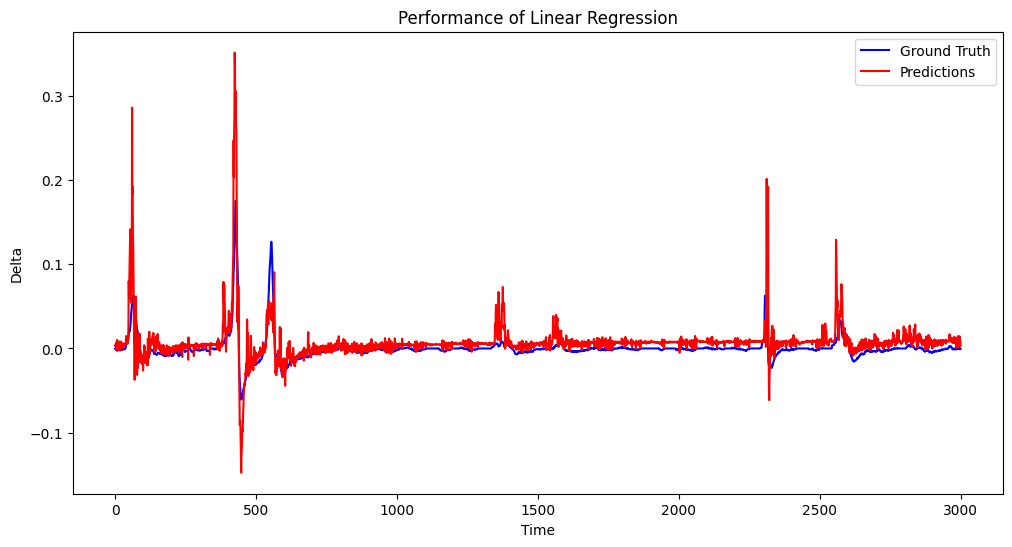

In [ ]:






# Train the best model on the first 50k examples
best_model = sorted_results[0][0]
model = dict(models)[best_model]
X_train_best = X_train.iloc[:50000]
y_train_best = y_train.iloc[:50000]
model.fit(X_train_best, y_train_best)

# Predict on the last 5k examples
X_test = X_train.iloc[45000:]
y_test = y_train.iloc[45000:]
predictions = model.predict(X_test)

# Produce a line plot with two lines, one line for the ground truth delta values, and one line showing your predictions.
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Ground Truth", color='blue')
plt.plot(predictions, label="Predictions", color='red')
plt.legend()
plt.title(f"Performance of {best_model}")
plt.xlabel("Time")
plt.ylabel("Delta")
plt.show()




Write a short paragraph commenting on that plot.
<br>You might want to comment on points like how well are the
spikes predicted, how well is the steady state predicted, are there
obvious delays in prediction, etc.

**Answer:**
>  The plot indicates that linear regression, which was shown to be the best of the evaluated models, does very well in predicting the steady state, as evidenced by the close alignment of the red prediction line with the blue ground truth line during periods of low variability. Spike events, however, are not predicted well. In some instances, the model appears to underpredict the magnitude of the spikes, and in others it greatly overpredicts. There does not seem to be any obvious delays in prediction.